In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from scipy.stats import norm

In [172]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Loading Data

Credit: Ahmad Hussein, Mohammed Ali

In [97]:
# reading data from csv files
train_imputed= pd.read_csv("train_imputed.csv")
train_undersampled_imputed= pd.read_csv("train_undersampled_imputed.csv")
train_oversampled_imputed= pd.read_csv("train_oversampled_imputed.csv")

test_imputed= pd.read_csv("test_imputed.csv")

In [98]:
# data processing
y_train_imputed = train_imputed.iloc[:,64]
x_train_imputed = train_imputed.drop('class', inplace=True, axis=1)
x_train_imputed = train_imputed.copy()

y_test_imputed = test_imputed.iloc[:,64]
x_test_imputed = test_imputed.drop('class', inplace=True, axis=1)
x_test_imputed = test_imputed.copy()

In [99]:
# winsorizing
for i in range(0,64):
        winsorize(x_train_imputed.iloc[:,0], limits=[0.1, 0.1])
        winsorize(x_test_imputed.iloc[:,0], limits=[0.1, 0.1])
        
x_train_imputed.describe();
x_test_imputed.describe();

Attribute dictionary for reference

In [100]:
attributes = {1: "net profit / total assets",
              2: "total liabilities / total assets",
              3: "working capital / total assets",
              4: "current assets / short-term liabilities",
              5: "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
              6: "retained earnings / total assets",
              7: "EBIT / total assets",
              8: "book value of equity / total liabilities",
              9: "sales / total assets",
             10: "equity / total assets",
             11: "(gross profit + extraordinary items + financial expenses) / total assets",
             12: "gross profit / short-term liabilities",
             13: "(gross profit + depreciation) / sales",
             14: "(gross profit + interest) / total assets",
             15: "(total liabilities * 365) / (gross profit + depreciation)",
             16: "(gross profit + depreciation) / total liabilities",
             17: "total assets / total liabilities",
             18: "gross profit / total assets",
             19: "gross profit / sales",
             20: "(inventory * 365) / sales",
             21: "sales (n) / sales (n-1)",
             22: "profit on operating activities / total assets",
             23: "net profit / sales",
             24: "gross profit (in 3 years) / total assets",
             25: "(equity - share capital) / total assets",
             26: "(net profit + depreciation) / total liabilities",
             27: "profit on operating activities / financial expenses",
             28: "working capital / fixed assets",
             29: "logarithm of total assets",
             30: "(total liabilities - cash) / sales",
             31: "(gross profit + interest) / sales",
             32: "(current liabilities * 365) / cost of products sold",
             33: "operating expenses / short-term liabilities",
             34: "operating expenses / total liabilities",
             35: "profit on sales / total assets",
             36: "total sales / total assets",
             37: "(current assets - inventories) / long-term liabilities",
             38: "constant capital / total assets",
             39: "profit on sales / sales",
             40: "(current assets - inventory - receivables) / short-term liabilities",
             41: "total liabilities / ((profit on operating activities + depreciation) * (12/365))",
             42: "profit on operating activities / sales",
             43: "rotation receivables + inventory turnover in days",
             44: "(receivables * 365) / sales",
             45: "net profit / inventory",
             46: "(current assets - inventory) / short-term liabilities",
             47: "(inventory * 365) / cost of products sold",
             48: "EBITDA (profit on operating activities - depreciation) / total assets",
             49: "EBITDA (profit on operating activities - depreciation) / sales",
             50: "current assets / total liabilities",
             51: "short-term liabilities / total assets",
             52: "(short-term liabilities * 365) / cost of products sold)",
             53: "equity / fixed assets",
             54: "constant capital / fixed assets",
             55: "working capital",
             56: "(sales - cost of products sold) / sales",
             57: "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)",
             58: "total costs /total sales",
             59: "long-term liabilities / equity",
             60: "sales / inventory",
             61: "sales / receivables",
             62: "(short-term liabilities *365) / sales",
             63: "sales / short-term liabilities",
             64: "sales / fixed assets"}

# Logistic Regression

## Initial Model

### Fit

In [101]:
from sklearn.linear_model import LogisticRegression

In [102]:
lr_model = LogisticRegression()

In [103]:
lr_model.fit(x_train_imputed, y_train_imputed)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [104]:
# predictions
lr_model_preds = lr_model.predict(x_test_imputed)

### Results

Accuracy

In [105]:
lr_model.score(x_test_imputed, y_test_imputed)

0.9523990860624524

Confusion Matrix

In [106]:
cm = metrics.confusion_matrix(y_test_imputed, lr_model_preds)
print(cm)

[[2500    2]
 [ 123    1]]


Precision, Recall, F Score

In [107]:
lr_model_results = precision_recall_fscore_support(y_test_imputed, lr_model_preds, average='macro')
lr_model_precision, lr_model_recall, lr_model_fscore, lr_model_support = lr_model_results
print("Precision: " + str(lr_model_precision))
print("Recall: " + str(lr_model_recall))
print("F Score: " + str(lr_model_fscore))

Precision: 0.64322023128733
Recall: 0.5036325778087208
F Score: 0.49567889379681196


PRAUC

In [108]:
lr_model_probas = lr_model.predict_proba(x_test_imputed)
average_precision_score(y_test_imputed, lr_model_probas[:,1],pos_label=1)

0.0815585536759609

### Interpretation

Coefficient magnitude:

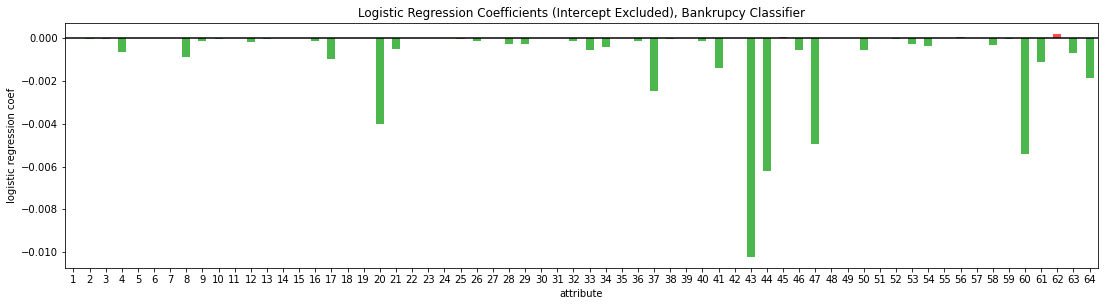

In [114]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(1,65),columns=["attr"])
to_plot["coef"] = lr_model.coef_[0]

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(1,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("logistic regression coef");
ax.set_title("Logistic Regression Coefficients (Intercept Excluded), Bankrupcy Classifier");

In [110]:
print("attribues that decrease predicted probability of bankrupcy (in desc order of coef size):")
print("====")
print(attributes[43])
print(attributes[60])
print(attributes[44])
print(attributes[47])
print(attributes[20])

attribues that decrease predicted probability of bankrupcy (in desc order of coef size):
====
rotation receivables + inventory turnover in days
sales / inventory
(receivables * 365) / sales
(inventory * 365) / cost of products sold
(inventory * 365) / sales


Coefficient significance:

In [111]:
# significanc helper function, from user David Dale, stack overflow
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

In [112]:
# finding coefficient significance
lr_model_sigs = logit_pvalue(lr_model, x_train_imputed)

<ipython-input-111-49e2cea538da>:18: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))


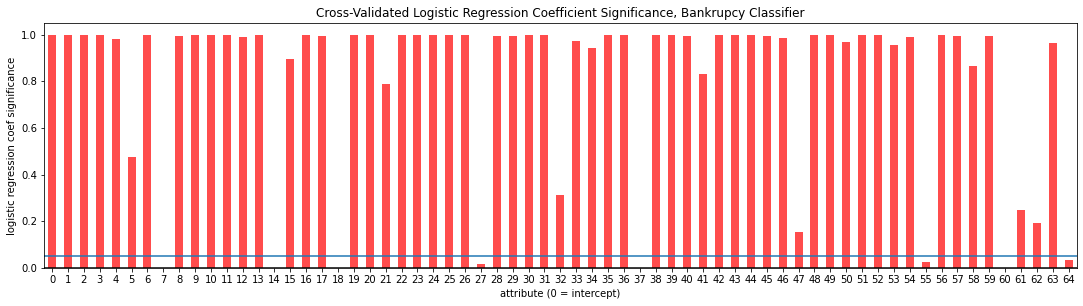

In [113]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(0,65),columns=["attr"])
to_plot["significance"] = lr_model_sigs

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['significance'] > 0
to_plot['significance'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(0,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute (0 = intercept)");
ax.set_ylabel("logistic regression coef significance");
ax.set_title("Cross-Validated Logistic Regression Coefficient Significance, Bankrupcy Classifier");
ax.axhline(0.05);

In [150]:
print("attibutes with significant (p<=0.05) regression coefficients:")
print("====")
print(attributes[7])
print(attributes[14])
print(attributes[18])
print(attributes[27])
print(attributes[37])
print(attributes[55])
print(attributes[60])
print(attributes[64])

attibutes with significant (p<=0.05) regression coefficients:
====
EBIT / total assets
(gross profit + interest) / total assets
gross profit / total assets
profit on operating activities / financial expenses
(current assets - inventories) / long-term liabilities
working capital
sales / inventory
sales / fixed assets


## Sparse Model

Retraining using only significant coefficients

### Fit

In [116]:
lr_model2 = LogisticRegression()

In [124]:
# x imputed with only significant regression coefficients included
x_train_signif = x_train_imputed[["Attr7","Attr14","Attr18","Attr27","Attr37","Attr55","Attr60","Attr64"]]
x_test_signif = x_test_imputed[["Attr7","Attr14","Attr18","Attr27","Attr37","Attr55","Attr60","Attr64"]]

In [125]:
 lr_model2.fit(x_train_signif, y_train_imputed)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [127]:
# predictions
lr_model2_preds = lr_model2.predict(x_test_signif)

### Results

Accuracy

In [129]:
lr_model2.score(x_test_signif, y_test_imputed)

0.9478293983244478

Confusion Matrix

In [131]:
cm = metrics.confusion_matrix(y_test_imputed, lr_model2_preds)
print(cm)

[[2487   15]
 [ 122    2]]


Precision, Recall, F Score

In [132]:
lr_model2_results = precision_recall_fscore_support(y_test_imputed, lr_model2_preds, average='macro')
lr_model2_precision, lr_model2_recall, lr_model2_fscore, lr_model2_support = lr_model2_results
print("Precision: " + str(lr_model2_precision))
print("Recall: " + str(lr_model2_recall))
print("F Score: " + str(lr_model2_fscore))

Precision: 0.5354429238157509
Recall: 0.505066914210567
F Score: 0.5007819318921364


PRAUC

In [133]:
lr_model2_probas = lr_model2.predict_proba(x_test_signif)
average_precision_score(y_test_imputed, lr_model2_probas[:,1],pos_label=1)

0.06002506778022618

### Interpretation

Coefficient magnitude:

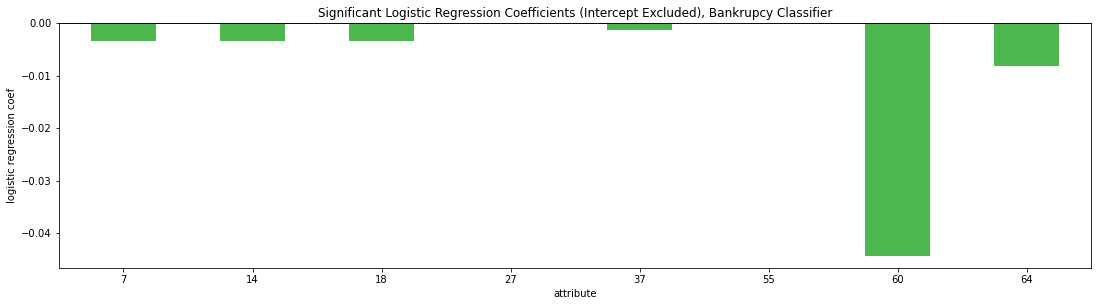

In [135]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame([7,14,18,27,37,55,60,64],columns=["attr"])
to_plot["coef"] = lr_model2.coef_[0]

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels([7,14,18,27,37,55,60,64], rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("logistic regression coef");
ax.set_title("Significant Logistic Regression Coefficients (Intercept Excluded), Bankrupcy Classifier");

In [136]:
print("significant attribues that decrease predicted probability of bankrupcy (in desc order of coef size):")
print("====")
print(attributes[60])

significant attribues that decrease predicted probability of bankrupcy (in desc order of coef size):
====
sales / inventory


## Cross-Validated Model

### Fit

Improving model performance using Regularization

In [137]:
# creating random grid
penalty = ['none','l2','l1','elaticnet']
lam = [x for x in np.linspace(start = 0, stop = 1, num = 100)]

# random grid
random_grid = {'penalty': penalty,'C':lam}

In [138]:
# random grid search
lr_model3 = LogisticRegression();
# random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lr_model3_rcv = RandomizedSearchCV(estimator = lr_model3, param_distributions = random_grid, 
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1);
lr_model3_rcv.fit(x_train_imputed, y_train_imputed);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.95137751 0.95163138 0.95137751        nan 0.95163133 0.95163138
 0.95175827        nan        nan        nan 0.95137746 0.95112359
 0.95163138 0.95163138 0.95163138        nan        nan 0.95163138
        nan 0.95125047 0.95137751        nan        nan        nan
 0.95163138 0.95163138        nan 0.95150439        nan 0.95163138
        nan 0.95125052 0.95137746 0.95163138 0.95163138 0.95163138
 0.95175827        nan        nan 0.95150439 0.95137746        nan
 0.95163138 0.95150439        nan        nan 0.95163138 0.95099665
        nan 0.95112359        nan 0.95163143        nan        nan
        nan        nan        nan 0.95163138        nan 0.95163138
 0.95163138        nan        nan        nan 0.95175831        nan
 0.95163138 0.95163138        nan 0.95150439 0.95163138 0.95163138
 0.95175841 0.95125052 0.95163138        nan        n

In [139]:
# cross-validated hyperparams
pprint(lr_model3_rcv.best_params_)

{'C': 0.010101010101010102, 'penalty': 'l2'}


In [140]:
# predictions
lr_model3_preds = lr_model3_rcv.predict(x_test_imputed)

### Results

In [141]:
# using cross-validation coefficients
lr_model3 = LogisticRegression(penalty='l2',C=0.14141414141414144)
lr_model3.fit(x_train_imputed, y_train_imputed)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.14141414141414144)

New Accuracy:

In [142]:
lr_model3.score(x_test_imputed, y_test_imputed)

0.9527798933739527

Confusion Matrix:

In [143]:
cm = metrics.confusion_matrix(y_test_imputed, lr_model3_preds)
print(cm)

[[2500    2]
 [ 123    1]]


Precision, Recall, F Score

In [144]:
lr_model3_results = precision_recall_fscore_support(y_test_imputed, lr_model3_preds, average='macro')
lr_model3_precision, lr_model3_recall, lr_model3_fscore, lr_model3_support = lr_model3_results
print("Precision: " + str(lr_model3_precision))
print("Recall: " + str(lr_model3_recall))
print("F Score: " + str(lr_model3_fscore))

Precision: 0.64322023128733
Recall: 0.5036325778087208
F Score: 0.49567889379681196


PRAUC:

In [145]:
lr_model3_probas = lr_model3.predict_proba(x_test_imputed)
average_precision_score(y_test_imputed, lr_model3_probas[:,1],pos_label=1)

0.07956668409215864

### Interpretation

Coefficient Magnitude:

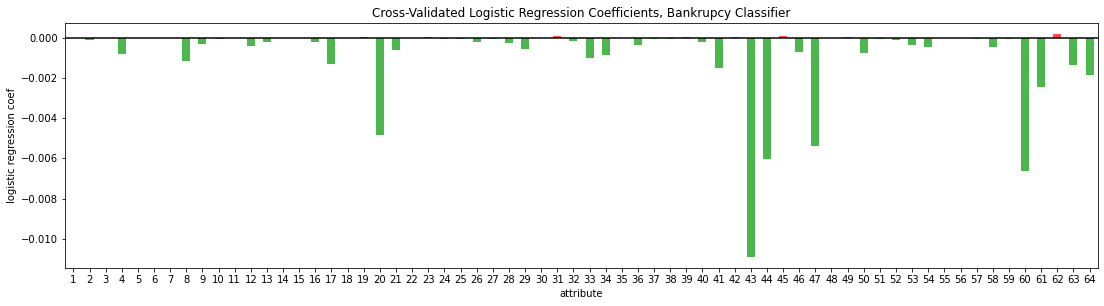

In [146]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(1,65),columns=["attr"])
to_plot["coef"] = lr_model3.coef_[0]

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(1,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("logistic regression coef");
ax.set_title("Cross-Validated Logistic Regression Coefficients, Bankrupcy Classifier");

In [147]:
print("attribues that decrease predicted probability of bankrupcy (in desc order of coef size):")
print("====")
print(attributes[43])
print(attributes[60])
print(attributes[44])
print(attributes[47])
print(attributes[20])

attribues that decrease predicted probability of bankrupcy (in desc order of coef size):
====
rotation receivables + inventory turnover in days
sales / inventory
(receivables * 365) / sales
(inventory * 365) / cost of products sold
(inventory * 365) / sales


Coefficient Significance:

In [148]:
# finding coefficient significance
lr_model3_sigs = logit_pvalue(lr_model3, x_train_imputed)

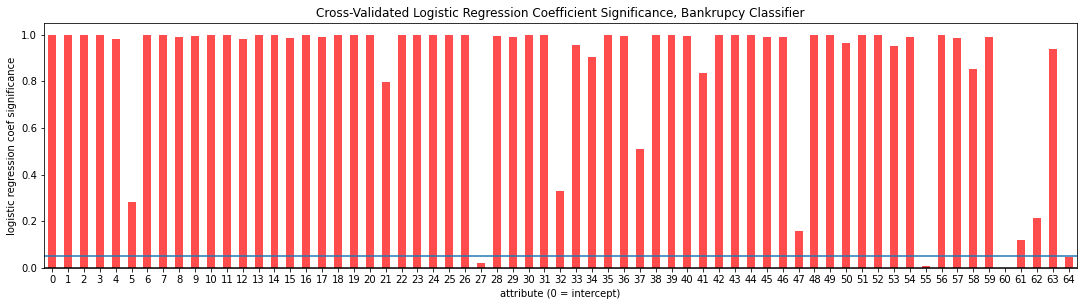

In [149]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(0,65),columns=["attr"])
to_plot["significance"] = lr_model3_sigs

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['significance'] > 0
to_plot['significance'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(0,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute (0 = intercept)");
ax.set_ylabel("logistic regression coef significance");
ax.set_title("Cross-Validated Logistic Regression Coefficient Significance, Bankrupcy Classifier");
ax.axhline(0.05);

In [153]:
print("attibutes with significant (p<=0.05) regression coefficients:")
print("====")
print(attributes[27])
print(attributes[55])
print(attributes[60])
print(attributes[64])

attibutes with significant (p<=0.05) regression coefficients:
====
profit on operating activities / financial expenses
working capital
sales / inventory
sales / fixed assets


## Sparsified -> Cross Validated Model

### Fit

Improving model performance using Regularization

In [154]:
# creating random grid
penalty = ['none','l2','l1','elaticnet']
lam = [x for x in np.linspace(start = 0, stop = 1, num = 100)]

# random grid
random_grid = {'penalty': penalty,'C':lam}

In [155]:
# x imputed with only significant regression coefficients included
x_train_signif = x_train_imputed[["Attr7","Attr14","Attr18","Attr27","Attr37","Attr55","Attr60","Attr64"]]
x_test_signif = x_test_imputed[["Attr7","Attr14","Attr18","Attr27","Attr37","Attr55","Attr60","Attr64"]]

In [156]:
# random grid search
lr_model4 = LogisticRegression();
# random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lr_model4_rcv = RandomizedSearchCV(estimator = lr_model4, param_distributions = random_grid, 
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1);
lr_model4_rcv.fit(x_train_signif, y_train_imputed);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.94845711 0.94477699 0.95150425        nan 0.94985437 0.94477699
 0.94960002        nan        nan        nan 0.94820416 0.95239309
 0.94477699 0.94477699 0.94477699        nan        nan 0.94477699
        nan 0.95226611 0.95163123        nan        nan        nan
 0.94477699 0.94477699        nan 0.94909266        nan 0.94477699
        nan 0.94985365 0.94833095 0.9497271  0.94477699 0.94477699
 0.9518852         nan        nan 0.94858453 0.95086918        nan
 0.94477699 0.94998126        nan        nan 0.94477699 0.94833115
        nan 0.9509968         nan 0.94947294        nan        nan
        nan        nan        nan 0.94477699        nan 0.94477699
 0.94477699        nan        nan        nan 0.95099636        nan
 0.94477699 0.94477699        nan 0.95175827 0.94477699 0.94477699
 0.94972676 0.94985433 0.94477699        nan        n

In [157]:
# cross-validated hyperparams
pprint(lr_model4_rcv.best_params_)

{'C': 0.9090909090909092, 'penalty': 'l2'}


In [158]:
# predictions
lr_model4_preds = lr_model4_rcv.predict(x_test_signif)

### Results

In [160]:
# using cross-validation coefficients
lr_model4 = LogisticRegression(penalty='l2',C=0.9090909090909092)
lr_model4.fit(x_train_signif, y_train_imputed)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.9090909090909092)

New accuracy

In [161]:
lr_model4.score(x_test_signif, y_test_imputed)

0.9527798933739527

Confusion Matrix

In [162]:
cm = metrics.confusion_matrix(y_test_imputed, lr_model4_preds)
print(cm)

[[2502    0]
 [ 124    0]]


Precision, Recall, F Score

In [163]:
lr_model4_results = precision_recall_fscore_support(y_test_imputed, lr_model4_preds, average='macro')
lr_model4_precision, lr_model4_recall, lr_model4_fscore, lr_model4_support = lr_model4_results
print("Precision: " + str(lr_model4_precision))
print("Recall: " + str(lr_model4_recall))
print("F Score: " + str(lr_model4_fscore))

Precision: 0.4763899466869764
Recall: 0.5
F Score: 0.4879095163806553


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PRAUC:

In [165]:
lr_model4_probas = lr_model4.predict_proba(x_test_signif)
average_precision_score(y_test_imputed, lr_model4_probas[:,1],pos_label=1)

0.0677652589091914

### Interpretation

Coefficient Importance

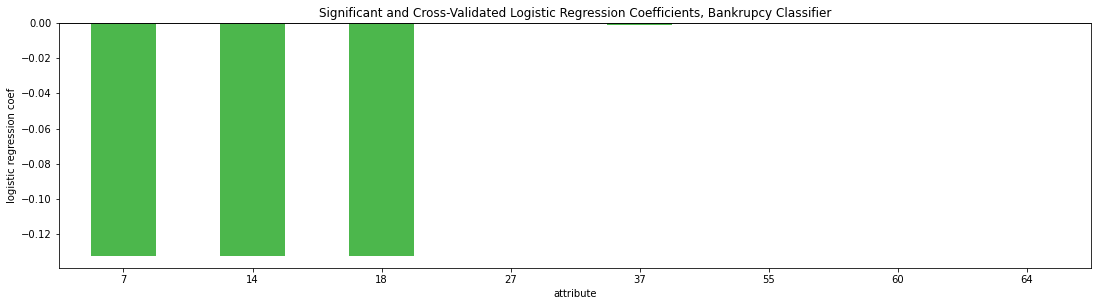

In [168]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame([7,14,18,27,37,55,60,64],columns=["attr"])
to_plot["coef"] = lr_model4.coef_[0]

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels([7,14,18,27,37,55,60,64], rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("logistic regression coef");
ax.set_title("Significant and Cross-Validated Logistic Regression Coefficients, Bankrupcy Classifier");

In [169]:
print("significant attribues that decrease predicted probability of bankrupcy (in desc order of coef size):")
print("====")
print(attributes[7])
print(attributes[14])
print(attributes[18])

significant attribues that decrease predicted probability of bankrupcy (in desc order of coef size):
====
EBIT / total assets
(gross profit + interest) / total assets
gross profit / total assets


# Random Forest

## Initial Model

### Fit

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rf_model = RandomForestClassifier(random_state=42)

In [29]:
rf_model.fit(x_train_imputed, y_train_imputed)

RandomForestClassifier(random_state=42)

In [144]:
# predictions
rf_model_preds = rf_model.predict(x_test_imputed)

### Results

Accuracy

In [145]:
rf_model.score(x_test_imputed, y_test_imputed)

0.952018278750952

Confusion Matrix

In [146]:
cm = metrics.confusion_matrix(y_test_imputed, rf_model_preds)
print(cm)

[[2498    4]
 [ 122    2]]


Precision, Recall, F Score

In [153]:
rf_model_results = precision_recall_fscore_support(y_test_imputed, rf_model_preds, average='macro')
rf_model_precision, rf_model_recall, rf_model_fscore, rf_model_support = rf_model_results
print("Precision: " + str(rf_model_precision))
print("Recall: " + str(rf_model_recall))
print("F Score: " + str(rf_model_fscore))

Precision: 0.6433842239185751
Recall: 0.5072651556174416
F Score: 0.5030847325263569


PRAUC:

In [186]:
rf_model_probas = rf_model.predict_proba(x_test_imputed)
average_precision_score(y_test_imputed, rf_model_probas[:,1],pos_label=1)

0.18584034850126874

## Cross-Validated Model

### Fit

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

In [42]:
# creating random grid
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [44]:
# random grid search 
rf_model2 = RandomForestClassifier();
# random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_model2_rcv = RandomizedSearchCV(estimator = rf_model2, param_distributions = random_grid, 
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1);
# Fit the random search model
rf_model2_rcv.fit(x_train_imputed, y_train_imputed);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  52.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  36.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  48.8s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time= 1.4min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 1.2min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 1.6min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 1.4min
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  49.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time= 1.7min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  14.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  47.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.5min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  30.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 1.7min
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  49.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  39.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  40.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  55.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  54.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  44.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 1.4min
[CV] END bootstrap=True, max_depth=80

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  51.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  40.2s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  51.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time= 1.4min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 1.2min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  33.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 1.6min
[CV] END bootstrap=True, max_depth

In [52]:
# optimal random forest parameters as found from grid search:
rf_model2_rcv.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [150]:
# predictions
rf_model2_preds = rf_model2_rcv.predict(x_test_imputed)

### Results

In [157]:
# using cross-validated hyperparameters
rf_model2 = RandomForestClassifier(n_estimators=1800,
                                  min_samples_split=5,
                                  min_samples_leaf=4,
                                  max_features='auto',
                                  max_depth=10,
                                  bootstrap=False)
rf_model2.fit(x_train_imputed, y_train_imputed)

/Users/DanielChung/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(bootstrap=False, max_depth=10, max_features='auto',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=1800)

Accuracy

In [158]:
rf_model2.score(x_test_imputed, y_test_imputed)

0.9527798933739527

Confusion Matrix

In [159]:
cm = metrics.confusion_matrix(y_test_imputed, rf_model2_preds)
print(cm)

[[2501    1]
 [ 123    1]]


Precision, Recall, F Score

In [160]:
rf_model2_results = precision_recall_fscore_support(y_test_imputed, rf_model2_preds, average='macro')
rf_model2_precision, rf_model2_recall, rf_model2_fscore, rf_model2_support = rf_model2_results
print("Precision: " + str(rf_model2_precision))
print("Recall: " + str(rf_model2_recall))
print("F Score: " + str(rf_model2_fscore))

Precision: 0.7265625
Recall: 0.5038324179366185
F Score: 0.4958413070001053


PRAUC:

In [187]:
rf_model2_probas = rf_model2.predict_proba(x_test_imputed)
average_precision_score(y_test_imputed, rf_model2_probas[:,1],pos_label=1)

0.22251801716103334

# CART

## Initial Model

### Fit

In [180]:
from sklearn.tree import DecisionTreeClassifier

In [181]:
cart_model = DecisionTreeClassifier(random_state=42)

In [182]:
cart_model.fit(x_train_imputed,y_train_imputed)

DecisionTreeClassifier(random_state=42)

In [183]:
# predictions
cart_model_preds = cart_model.predict(x_test_imputed)

### Results

Accuracy

In [184]:
cart_model.score(x_test_imputed,y_test_imputed)

0.9219345011424219

Confusion Matrix

In [185]:
cm = metrics.confusion_matrix(y_test_imputed, cart_model_preds)
print(cm)

[[2384  118]
 [  87   37]]


Precision, Recall, F Score

In [186]:
cart_model_results = precision_recall_fscore_support(y_test_imputed, cart_model_preds, average='macro')
cart_model_precision, cart_model_recall, cart_model_fscore, cart_model_support = cart_model_results
print("Precision: " + str(cart_model_precision))
print("Recall: " + str(cart_model_recall))
print("F Score: " + str(cart_model_fscore))

Precision: 0.6017506298873383
Recall: 0.6256124132951704
F Score: 0.6120051864296592


PRAUC

In [187]:
cart_model_probas = cart_model.predict_proba(x_test_imputed)
average_precision_score(y_test_imputed, cart_model_probas[:,1],pos_label=1)

0.10435812371759869

### Interpretation

In [189]:
from sklearn.tree import plot_tree

In [200]:
# from user bharys on stack overflow:
def dt_feature_importance(model,normalize=True):

    left_c = model.tree_.children_left
    right_c = model.tree_.children_right

    impurity = model.tree_.impurity    
    node_samples = model.tree_.weighted_n_node_samples 

    # Initialize the feature importance, those not used remain zero
    feature_importance = np.zeros((model.tree_.n_features,))

    for idx,node in enumerate(model.tree_.feature):
        if node >= 0:
            # Accumulate the feature importance over all the nodes where it's used
            feature_importance[node]+=impurity[idx]*node_samples[idx]- \
                                   impurity[left_c[idx]]*node_samples[left_c[idx]]-\
                                   impurity[right_c[idx]]*node_samples[right_c[idx]]

    # Number of samples at the root node
    feature_importance/=node_samples[0]

    if normalize:
        normalizer = feature_importance.sum()
        if normalizer > 0:
            feature_importance/=normalizer

    return feature_importance

In [203]:
cart_model_importances = dt_feature_importance(cart_model)

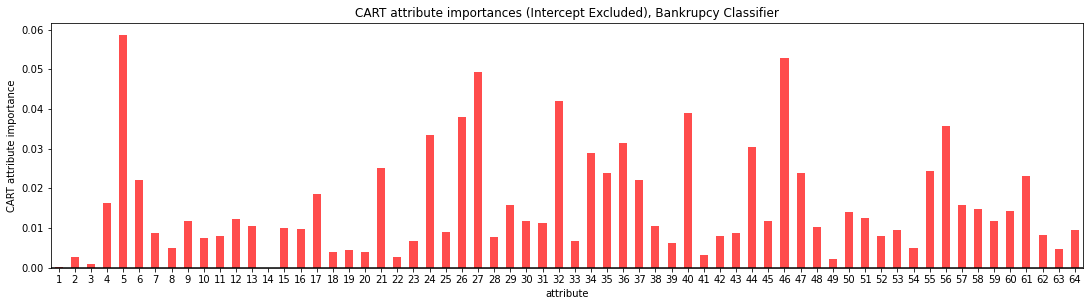

In [205]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(1,65),columns=["attr"])
to_plot["coef"] = cart_model_importances

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(1,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("CART attribute importance");
ax.set_title("CART attribute importances (Intercept Excluded), Bankrupcy Classifier");

In [206]:
print("attribues that decrease predicted probability of bankrupcy (in desc order of coef importance):")
print("====")
print(attributes[5])
print(attributes[46])
print(attributes[27])
print(attributes[32])

attribues that decrease predicted probability of bankrupcy (in desc order of coef importance):
====
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
(current assets - inventory) / short-term liabilities
profit on operating activities / financial expenses
(current liabilities * 365) / cost of products sold


## Cross-Validated Model

### Fit

In [240]:
# creating random grid
criterion = ["gini", "entropy", "log_loss"]
max_depth = range(1,10)
min_samples_split = range(1,5)
min_samples_leaf = range(1,5)
ccp_alpha = np.linspace(0,1,18)

# random grid
random_grid = {'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'ccp_alpha': ccp_alpha}

In [241]:
# random grid search
cart_model2 = DecisionTreeClassifier();
# random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
cart_model2_rcv = RandomizedSearchCV(estimator = cart_model2, param_distributions = random_grid, 
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1);
cart_model2_rcv.fit(x_train_imputed, y_train_imputed);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.95290088        nan 0.95290088 0.95290088        nan        nan
        nan        nan 0.95290088        nan 0.95290088 0.95290088
        nan        nan        nan        nan 0.95290088        nan
 0.95290088        nan        nan        nan        nan        nan
        nan 0.95290088        nan 0.9527739         nan 0.95290088
        nan 0.95290088        nan        nan 0.95290088        nan
        nan 0.95290088 0.95290088 0.95290088 0.95290088 0.95290088
        nan        nan        nan 0.95290088 0.95290088 0.95290088
 0.95290088        nan        nan        nan        nan 0.95290088
        nan 0.95290088        nan 0.95290088        nan        nan
 0.95290088 0.95290088 0.95290088 0.95290088 0.94515683        nan
        nan 0.95290088 0.95290088 0.95290088 0.95290088        nan
        nan        nan 0.95290088        nan 0.952900

In [242]:
# cross-validated hyperparams
pprint(cart_model2_rcv.best_params_)

{'ccp_alpha': 0.1764705882352941,
 'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 2}


In [243]:
# predictions
cart_model2_preds = cart_model2_rcv.predict(x_test_imputed)

### Results

In [244]:
cart_model2 = DecisionTreeClassifier(ccp_alpha=0.1764705882352941,
                                     criterion='gini',
                                     max_depth=8,
                                     min_samples_leaf=4,
                                     min_samples_split=2,
                                     random_state=42)
cart_model2.fit(x_train_imputed, y_train_imputed)

DecisionTreeClassifier(ccp_alpha=0.1764705882352941, max_depth=8,
                       min_samples_leaf=4, random_state=42)

New Accuracy

In [245]:
cart_model2.score(x_test_imputed, y_test_imputed)

0.9527798933739527

Confusion Matrix

In [246]:
cm = metrics.confusion_matrix(y_test_imputed, cart_model2_preds)
print(cm)

[[2502    0]
 [ 124    0]]


Precision, Recall, F Score

In [247]:
cart_model2_results = precision_recall_fscore_support(y_test_imputed, cart_model2_preds, average='macro')
cart_model2_precision, cart_model2_recall, cart_model2_fscore, cart_model2_support = cart_model2_results
print("Precision: " + str(cart_model2_precision))
print("Recall: " + str(cart_model2_recall))
print("F Score: " + str(cart_model2_fscore))

Precision: 0.4763899466869764
Recall: 0.5
F Score: 0.4879095163806553


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PRAUC

In [248]:
cart_model2_probas = cart_model2.predict_proba(x_test_imputed)
average_precision_score(y_test_imputed, cart_model2_probas[:,1],pos_label=1)

0.04722010662604722

### Interpretation

Coefficient Importances

In [249]:
cart_model2_importances = dt_feature_importance(cart_model2)

[Text(167.4, 108.72, 'gini = 0.09\nsamples = 7877\nvalue = [7506, 371]')]

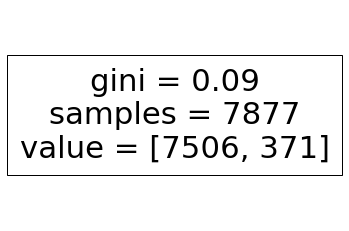

In [250]:
plot_tree(cart_model2, feature_names=list(attributes.values()))

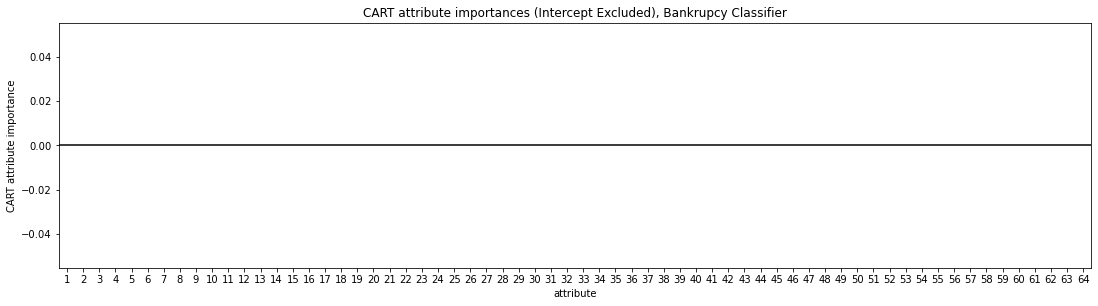

In [251]:
# creating a dataframe where rows are features
# and columns are logistic regression coef
to_plot = pd.DataFrame(range(1,65),columns=["attr"])
to_plot["coef"] = cart_model2_importances

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 4.5)

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}), 
                      ax=ax)
ax.set_xticklabels(range(1,65), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("attribute");
ax.set_ylabel("CART attribute importance");
ax.set_title("CART attribute importances (Intercept Excluded), Bankrupcy Classifier");

Here interpretation is less relevant beause the cross-validated hyperparameters cause the tree to coalesce into a single leaf. This preserves accuracy at the cost of interpretability, since there are no variables this tree splits on.